In [ ]:
"""!pip uninstall --y torch torchvision
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html"""

'!pip uninstall --y torch torchvision\n!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html'

In [ ]:
pip install mnist

In [ ]:
import mnist
images = mnist.train_images()
print(images.shape)

testImages =  mnist.test_images()
print(testImages.shape)

(60000, 28, 28)
(10000, 28, 28)


In [15]:
from pathlib import Path
import os
import torch.nn
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
import random
from torchvision.transforms import *
savepath = Path ("model.pch")
device = torch.device("cuda")
import matplotlib.pyplot as plt
# Téléchargement des données

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()
# Tensorboard : rappel, lancer dans une console tensorboard --logdir runs
writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Pour visualiser
# Les images doivent etre en format Channel (3) x Hauteur x Largeur
images = torch.tensor(train_images[0:8]).unsqueeze(1).repeat(1,3,1,1).double()/255.
# Permet de fabriquer une grille d'images
images = make_grid(images)
# Affichage avec tensorboard
writer.add_image(f'samples', images, 0)


savepath = Path("model.pch")

#  TODO: 
class MonDataset(Dataset):
    def __init__(self,datax,datay,normalize=None):
        self.datax = torch.tensor(datax,dtype=torch.float64)
        self.datay = torch.tensor(datay,dtype=torch.float64)
        if normalize:
            self.datax = self.datax.sub_(torch.min(self.datax)).div_(torch.max(self.datax) - torch.min(self.datax))
            
    def __getitem__(self,index):
        return self.datax[index],self.datay[index]
    
    def __len__(self):
        return self.datay.shape[0]

class State:
    def __init__(self,model,optim):
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0, 0


data = DataLoader(MonDataset(train_images,train_labels,normalize=True),shuffle=True , batch_size=200)
dataTest = DataLoader(MonDataset(test_images,test_labels,normalize=True),shuffle=True , batch_size=1000)
print(torch.cuda.is_available())
device = torch.device("cuda")

True


# Encodeur

In [16]:
class Encoder(nn.Module):
    def __init__(self, nb_features , dim_enc):
        super(Encoder, self).__init__()
        self.W = torch.nn.Parameter(torch.randn((nb_features,dim_enc), dtype=torch.float64, device="cuda"))
        self.b_enc = torch.nn.Parameter(torch.randn((1,dim_enc), dtype=torch.float64, device="cuda")) 
        self.b_dec = torch.nn.Parameter(torch.randn((1,nb_features), dtype=torch.float64, device="cuda"))

    def encode(self,X):
      return F.relu(F.linear(X,self.W.T,self.b_enc))

    def decode(self,X):
      return torch.sigmoid(F.linear(X,self.W,self.b_dec))

    def forward(self,X):
        X_enc = self.encode(X)
        X_dec = self.decode(X_enc)
        return X_dec

    def parameters(self):
        return [self.W,self.b_enc,self.b_dec]

In [17]:
class EncoderOptimization:
    def __init__(self, train_images, train_labels, test_images,test_labels, model, optimizer, criterion, normalize=True, shuffle=True, batch_size=200, dim_enc=50, epsilon=0.05, verbose=True):
        self.batch_size = batch_size
        self.dim_enc = dim_enc
        self.shuffle = shuffle
        self.normalize = normalize
        self.trainData = DataLoader(MonDataset(train_images,train_labels, self.normalize), self.batch_size, self.shuffle)
        self.testData = DataLoader(MonDataset(test_images,test_labels, self.normalize) , self.batch_size, self.shuffle)
        self.batch_size = data.batch_size
        self.dim_data = data.dataset[0][0].shape[0] * data.dataset[0][0].shape[1]
        self.model = model(self.dim_data, self.dim_enc).to(device)
        if optimizer == "adam":
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=epsilon)
        if criterion == "mse":
            self.criterion = nn.MSELoss()
        self.trainError = []
        self.testError = []
        self.verbose = verbose
        if savepath.is_file():
            with savepath.open("rb") as fp:
                self.state = torch.load(fp)
        else:
            self.state = State(self.model, self.optimizer)

    def run(self,epochs=100):
        train_set = self.trainData
        startEpoch = self.state.epoch
        for epoch in range(startEpoch,epochs):
            loss = 0
            for ind_batch in self.trainData.batch_sampler:
                batch = self.trainData.dataset[ind_batch][0]
                batch = batch.view((-1,self.dim_data)).clone().detach().to(device)
                self.state.optim.zero_grad()
                outputs = self.state.model.forward(batch)
                train_loss = self.criterion(outputs, batch)
                train_loss.backward()
                self.state.optim.step()
                loss += train_loss.item()
            
            loss = loss/len(data.batch_sampler)
            self.trainError.append(loss)
            with torch.no_grad():
              testOutput = self.state.model.forward(self.testData.dataset.datax.view(-1,self.dim_data).to(device))
              test_loss = self.criterion(testOutput, self.testData.dataset.datax.view(-1,self.dim_data).to(device))
              self.testError.append(test_loss)
            if (epoch%10 == 0):
                print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}".format(self.state.epoch, epochs, loss, test_loss))
            with savepath.open("wb") as fp:
                self.state.epoch = epoch + 1
                torch.save(self.state, fp)
        if self.verbose==True:
            plt.plot([i for i in range(startEpoch,epochs)],self.trainError,label="Train")
            plt.plot([i for i in range(startEpoch,epochs)],self.testError,label="Test")
            plt.xlabel("nb itérations")
            plt.ylabel("Loss")
            plt.title("Loss sur les données MNIST, {} neurones cachés".format(self.dim_enc))
            plt.legend()
            plt.savefig("mnistLoss {} neurons".format(self.dim_enc))
            plt.show()
        if savepath.is_file():
            os.remove(savepath)
        return self.trainError, self.testError

# Campagne d'expérimentation

epoch : 0/100, train loss = 0.154541, test loss = 0.096275
epoch : 10/100, train loss = 0.056283, test loss = 0.054929
epoch : 20/100, train loss = 0.050924, test loss = 0.049941
epoch : 30/100, train loss = 0.048952, test loss = 0.048073
epoch : 40/100, train loss = 0.047455, test loss = 0.046704
epoch : 50/100, train loss = 0.046768, test loss = 0.045999
epoch : 60/100, train loss = 0.045991, test loss = 0.045192
epoch : 70/100, train loss = 0.041543, test loss = 0.040722
epoch : 80/100, train loss = 0.022909, test loss = 0.021582
epoch : 90/100, train loss = 0.016022, test loss = 0.015884


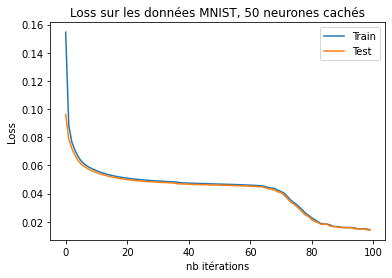

In [ ]:
Experiment = EncoderOptimization(train_images, train_labels, test_images,test_labels, Encoder, "adam", "mse", normalize=True, shuffle=True, batch_size=200, dim_enc=50, epsilon=0.005)
train1, test1 = Experiment.run()

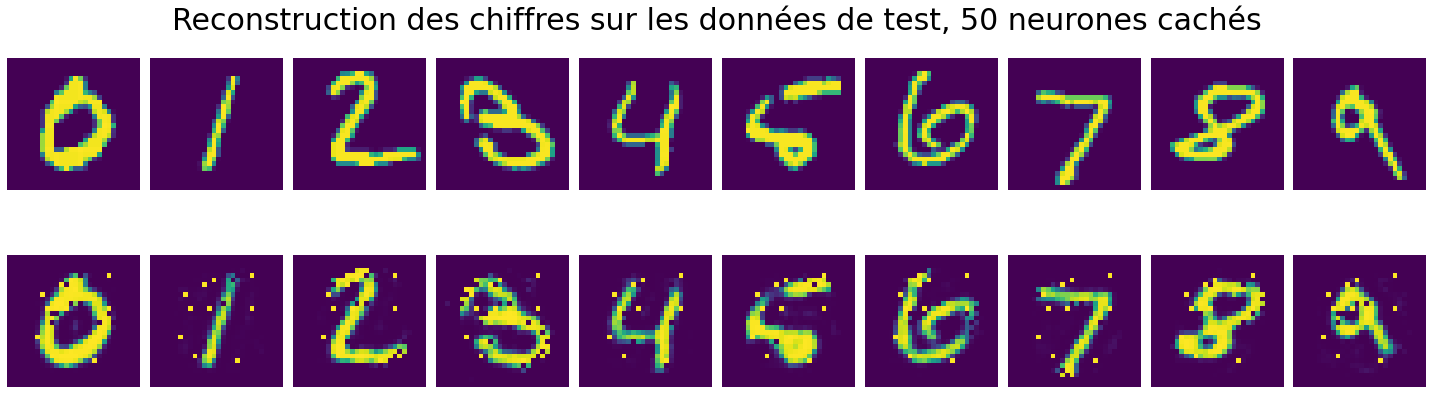

In [ ]:
arrWhere = []
for i in range(10):
    elt = np.where(dataTest.dataset.datay == i)
    arrWhere.append(elt)
i=1
figure = plt.figure(figsize = (20, 20))
for elt in arrWhere:
    ax1 = figure.add_subplot(2,10,i).axis('off')
    rd = random.randint(0,elt[0].shape[0]-1)
    plt.imshow(dataTest.dataset[elt[0][0]][0])
    plt.tight_layout()
    ax1 = figure.add_subplot(2,10,i+10).axis('off')
    plt.imshow(Experiment.state.model(dataTest.dataset[elt[0][0]][0].clone().detach().to(device).reshape((-1,784))).detach().reshape((28,28)).cpu())
    plt.tight_layout()
    i += 1
plt.tight_layout()
figure.suptitle("Reconstruction des chiffres sur les données de test, 50 neurones cachés", fontsize=30,y=0.65)
plt.tight_layout()
plt.savefig("reconstruct 50 neurons")
plt.show()

epoch : 0/100, train loss = 0.165932, test loss = 0.106161
epoch : 10/100, train loss = 0.067462, test loss = 0.065911
epoch : 20/100, train loss = 0.060894, test loss = 0.059526
epoch : 30/100, train loss = 0.057588, test loss = 0.056408
epoch : 40/100, train loss = 0.049906, test loss = 0.047768
epoch : 50/100, train loss = 0.036939, test loss = 0.036006
epoch : 60/100, train loss = 0.030613, test loss = 0.029863
epoch : 70/100, train loss = 0.028635, test loss = 0.027971
epoch : 80/100, train loss = 0.026594, test loss = 0.025912
epoch : 90/100, train loss = 0.025760, test loss = 0.025163


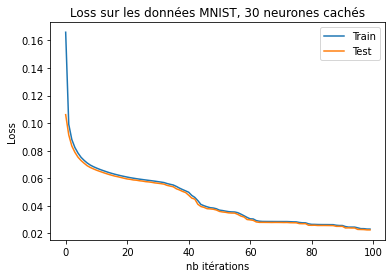

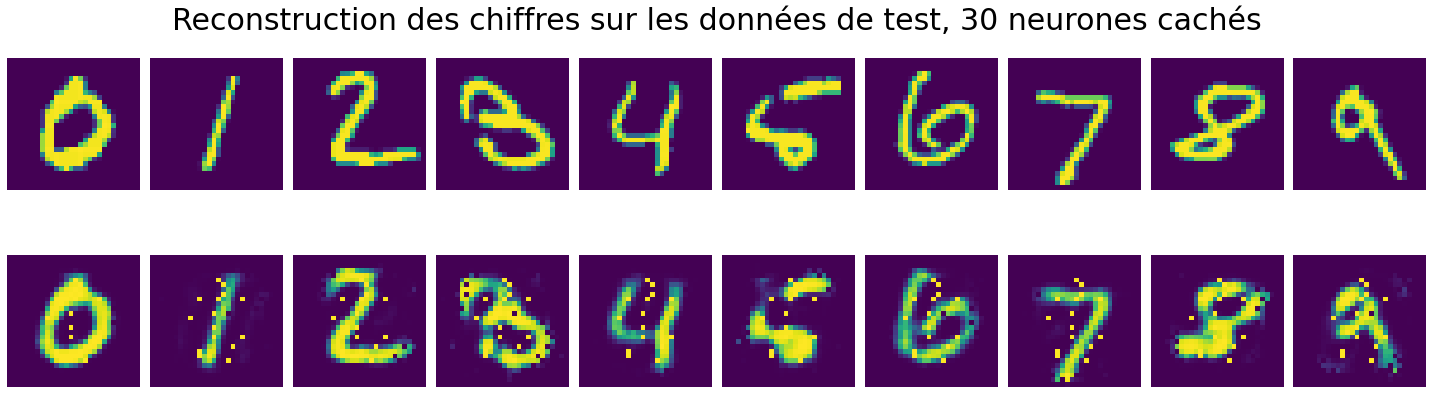

In [ ]:
Experiment = EncoderOptimization(train_images, train_labels, test_images,test_labels, Encoder, "adam", "mse", normalize=True, shuffle=True, batch_size=200, dim_enc=30, epsilon=0.005)
train2, test2 = Experiment.run()
arrWhere = []
for i in range(10):
    elt = np.where(dataTest.dataset.datay == i)
    arrWhere.append(elt)
i=1
figure = plt.figure(figsize = (20, 20))
for elt in arrWhere:
    ax1 = figure.add_subplot(2,10,i).axis('off')
    rd = random.randint(0,elt[0].shape[0]-1)
    plt.imshow(dataTest.dataset[elt[0][0]][0])
    plt.tight_layout()
    ax1 = figure.add_subplot(2,10,i+10).axis('off')
    plt.imshow(Experiment.state.model(dataTest.dataset[elt[0][0]][0].clone().detach().to(device).reshape((-1,784))).detach().reshape((28,28)).cpu())
    plt.tight_layout()
    i += 1
plt.tight_layout()
figure.suptitle("Reconstruction des chiffres sur les données de test, 30 neurones cachés", fontsize=30,y=0.65)
plt.tight_layout()
plt.savefig("reconstruct 30 neurons")
plt.show()

epoch : 0/20, train loss = 0.189173, test loss = 0.121753
epoch : 10/20, train loss = 0.080111, test loss = 0.077758


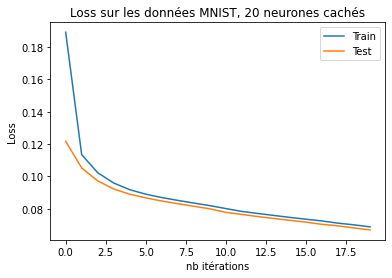

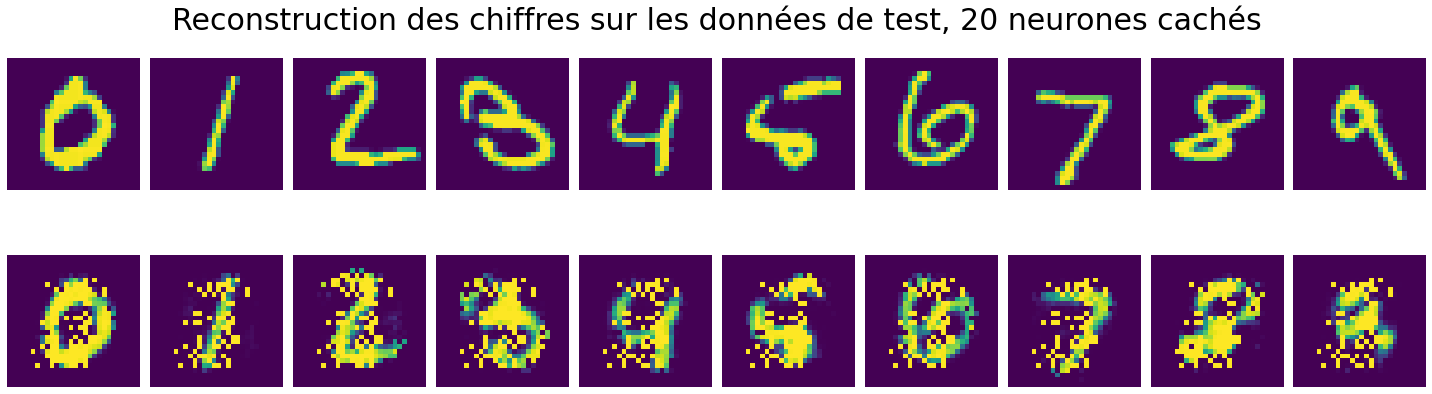

In [ ]:
Experiment = EncoderOptimization(train_images, train_labels, test_images,test_labels, Encoder, "adam", "mse", normalize=True, shuffle=True, batch_size=200, dim_enc=20, epsilon=0.005)
train3, test3 = Experiment.run(20)
arrWhere = []
for i in range(10):
    elt = np.where(dataTest.dataset.datay == i)
    arrWhere.append(elt)
i=1
figure = plt.figure(figsize = (20, 20))
for elt in arrWhere:
    ax1 = figure.add_subplot(2,10,i).axis('off')
    rd = random.randint(0,elt[0].shape[0]-1)
    plt.imshow(dataTest.dataset[elt[0][0]][0])
    plt.tight_layout()
    ax1 = figure.add_subplot(2,10,i+10).axis('off')
    plt.imshow(Experiment.state.model(dataTest.dataset[elt[0][0]][0].clone().detach().to(device).reshape((-1,784))).detach().reshape((28,28)).cpu())
    plt.tight_layout()
    i += 1
plt.tight_layout()
figure.suptitle("Reconstruction des chiffres sur les données de test, 20 neurones cachés", fontsize=30,y=0.65)
plt.tight_layout()
plt.savefig("reconstruct 20 neurons")
plt.show()

epoch : 0/100, train loss = 0.130475, test loss = 0.077304
epoch : 10/100, train loss = 0.039972, test loss = 0.039043
epoch : 20/100, train loss = 0.036032, test loss = 0.035426
epoch : 30/100, train loss = 0.034663, test loss = 0.034194
epoch : 40/100, train loss = 0.034064, test loss = 0.033660
epoch : 50/100, train loss = 0.033721, test loss = 0.033271
epoch : 60/100, train loss = 0.033505, test loss = 0.033086
epoch : 70/100, train loss = 0.033355, test loss = 0.032943
epoch : 80/100, train loss = 0.033223, test loss = 0.032932
epoch : 90/100, train loss = 0.033144, test loss = 0.032783


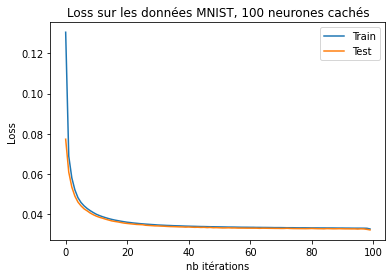

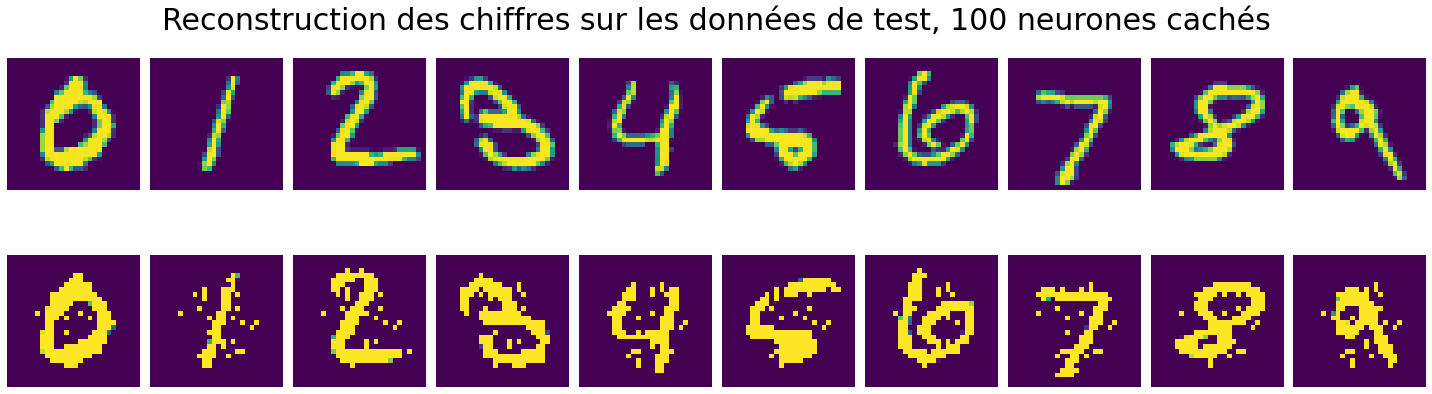

In [ ]:
Experiment = EncoderOptimization(train_images, train_labels, test_images,test_labels, Encoder, "adam", "mse", normalize=True, shuffle=True, batch_size=200, dim_enc=100, epsilon=0.005)
Experiment.run()
arrWhere = []
for i in range(10):
    elt = np.where(dataTest.dataset.datay == i)
    arrWhere.append(elt)
i=1
figure = plt.figure(figsize = (20, 20))
for elt in arrWhere:
    ax1 = figure.add_subplot(2,10,i).axis('off')
    rd = random.randint(0,elt[0].shape[0]-1)
    plt.imshow(dataTest.dataset[elt[0][0]][0])
    plt.tight_layout()
    ax1 = figure.add_subplot(2,10,i+10).axis('off')
    plt.imshow(Experiment.state.model(dataTest.dataset[elt[0][0]][0].clone().detach().to(device).reshape((-1,784))).detach().reshape((28,28)).cpu())
    plt.tight_layout()
    i += 1
plt.tight_layout()
figure.suptitle("Reconstruction des chiffres sur les données de test, 100 neurones cachés", fontsize=30,y=0.65)
plt.tight_layout()
plt.savefig("reconstruct 100 neurons")
plt.show()

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train3)

40

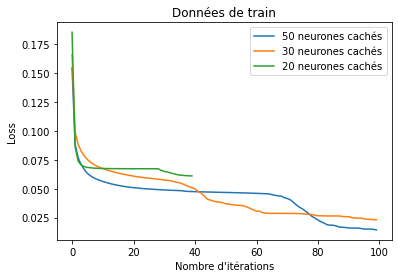

In [ ]:
plt.plot([i for i in range(100)],train1, label= "50 neurones cachés")
plt.plot([i for i in range(100)],train2, label= "30 neurones cachés")
plt.plot([i for i in range(40)],train3, label= "20 neurones cachés")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Loss")
plt.title("Données de train")
plt.legend()
plt.savefig("trainAE")
plt.show()

In [ ]:
plt.plot([i for i in range(100)],test1, label= "50 neurones cachés")
plt.plot([i for i in range(100)],test2, label= "30 neurones cachés")
plt.plot([i for i in range(100)],test3, label= "20 neurones cachés")
plt.xlabel("Nombre d'itérations")
plt.title("Données de test")
plt.ylabel("Loss")
plt.legend()
plt.savefig("testAE")
plt.show()

In [ ]:
def plot_reconstruction(dataTest,arrayDimEncodage,arrayRun):
  n = len(arrayDimEncodage)+1
  figure = plt.figure(figsize = (20, 20))
  arrWhere = []
  for i in range(10):
    elt = np.where(dataTest.dataset.datay == i)
    arrWhere.append(elt)
  i=1
  figure = plt.figure(figsize = (20, 20))
  for elt in arrWhere:
    ax1 = figure.add_subplot(n,10,i).axis('off')
    plt.imshow(dataTest.dataset[elt[0][0]][0])
    plt.tight_layout()
    i+=1
  plt.tight_layout()
  i = 1
  for k in range(len(arrayDimEncodage)):
    Experiment = EncoderOptimization(train_images, train_labels, test_images,test_labels, Encoder, "adam", "mse", normalize=True, shuffle=True, batch_size=200, dim_enc=arrayDimEncodage[k], epsilon=0.005,verbose=False)
    Experiment.run(arrayRun[k])
    for elt in arrWhere:
      ax1 = figure.add_subplot(n,10,i+10).axis('off')
      plt.imshow(Experiment.state.model(dataTest.dataset[elt[0][0]][0].clone().detach().to(device).reshape((-1,784))).detach().reshape((28,28)).cpu())
      plt.tight_layout()
      i += 1
    plt.tight_layout()
  figure.suptitle("Reconstruction des chiffres en test pour respectivement 20, 30 et 50 neurones cachés", fontsize=30,y=0.85)
  plt.tight_layout()
  plt.savefig("reconstruct final")
  plt.show()

In [ ]:
plot_reconstruction(dataTest,[20,30,50],[40,100,100])

In [12]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
datax, datay = load_boston(return_X_y=True)
datax = torch.from_numpy(datax)
datay = torch.from_numpy(datay.reshape(-1,1))
scaler = StandardScaler()
datax = scaler.fit_transform(datax)
X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size=0.30)
X_train = torch.tensor(X_train,dtype=torch.float64)
X_test = torch.tensor(X_test,dtype=torch.float64)

# Highway Network

In [34]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

class MSE(Function):
    """Début d'implementation de la fonction MSE"""
    @staticmethod
    def forward(yhat, y):
        ## Garde les valeurs nécessaires pour le backwards
        q = yhat.shape[0]
        return (1/q) * ((yhat.detach()-y.detach())**2).sum()
        #  TODO:  Renvoyer la valeur de la fonction

class Highway(nn.Module):
    def __init__(self, num_layers,Xtrain,Xtest,ytrain,ytest, batch_size=30,epsilon=0.05,verbose=True):
        super(Highway, self).__init__()
        self.Xtrain = Xtrain
        self.Xtest = Xtest
        self.ytrain = ytrain
        self.ytest = ytest
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.writer = SummaryWriter()
        self.nb_samples = Xtrain.shape[0]
        size = Xtrain.shape[1]
        self.verbose = verbose
        self.nbBatchs = int(self.nb_samples/self.batch_size)
        self.trainError = []
        self.testError = []
        self.num_layers = num_layers
        self.nonlinear = nn.ModuleList([nn.Linear(size, size).double() for _ in range(num_layers)]+[nn.Linear(size, 1).double()])
        self.linear = nn.ModuleList([nn.Linear(size, size).double() for _ in range(num_layers)]+[nn.Linear(size, 1).double()])
        self.gate = nn.ModuleList([nn.Linear(size, size).double() for _ in range(num_layers)]+[nn.Linear(size, 1).double()])
        self.layers = [self.nonlinear,self.linear,self.gate]
        self.f = nn.LeakyReLU()
        self.optim = torch.optim.Adam(params=(par for layer in self.layers for par in layer.parameters()),lr=self.epsilon)
        self.optim.zero_grad()

    def forward(self, x):
        for layer in range(self.num_layers+1):
            gate = F.sigmoid(self.gate[layer](x))
            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)
            x = gate * nonlinear + (1 - gate) * linear
        return x
    
    def run(self,nb_epochs=100):
        for n_iter in range(nb_epochs):
            perm = [torch.randperm(self.nb_samples)[k:k+self.batch_size] for k in range(self.nbBatchs)]
            for mini_batch in perm:
                yhat = self.forward(self.Xtrain[mini_batch])
                loss = MSE.forward(yhat,self.ytrain[mini_batch])
                loss.backward()
                self.optim.step() # Mise-à-jour des paramètres w et b
                self.optim.zero_grad() # Reinitialisation du gradient
            yhat = self.forward(self.Xtrain)
            trainLoss = MSE.forward(yhat,self.ytrain)
            self.trainError.append(trainLoss)
            self.writer.add_scalar('Loss/train', trainLoss, n_iter)
            with torch.no_grad():
                #forward + loss sur test
                yhat = self.forward(self.Xtest)
                testLoss = MSE.forward(yhat,self.ytest)
                self.testError.append(testLoss)
            if (n_iter % 50 == 0):
                #print(f"Itérations {n_iter}: loss {trainLoss}")
                print(f"Itérations {n_iter}: test loss {testLoss}")
        print(f"Itérations {n_iter}: test loss {testLoss}")
        #Cumul loss
        if self.verbose == True:
            plt.plot([i for i in range(nb_epochs)],self.trainError,label="Train Error")
            plt.plot([i for i in range(nb_epochs)],self.testError,label="Test error")
            if self.batch_size == 1:
                plt.title("Descente de gradient stochastique, epsilon={}".format(self.epsilon))
            else:
                plt.title("Descente de gradient mini-batch, epsilon={}".format(self.epsilon))
            plt.xlabel("nb itérations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
        return self.trainError,self.testError

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Itérations 0: test loss 557.3563418874404
Itérations 50: test loss 215.41312395993668
Itérations 100: test loss 72.59326936093832
Itérations 150: test loss 35.82200010054112
Itérations 200: test loss 25.39928838035626
Itérations 250: test loss 19.9780168679409
Itérations 299: test loss 17.046896299074056


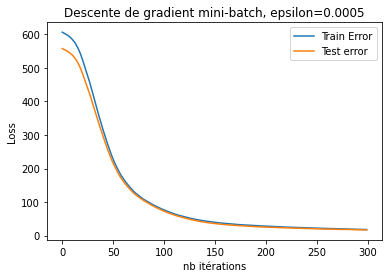

Itérations 0: test loss 558.0604653847938
Itérations 50: test loss 19.0956679149908
Itérations 100: test loss 13.352250278006514
Itérations 150: test loss 14.418740102142847
Itérations 200: test loss 12.94230224510306
Itérations 250: test loss 11.639206461850431
Itérations 299: test loss 12.296641001781255


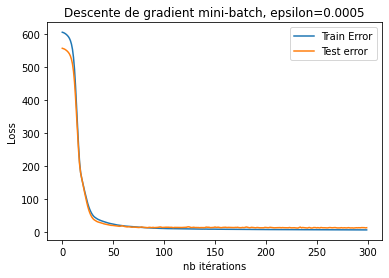

Itérations 0: test loss 548.9273347918038
Itérations 50: test loss 15.614648439947633
Itérations 100: test loss 13.240701355802047
Itérations 150: test loss 14.519301354944446
Itérations 200: test loss 14.794832058077546
Itérations 250: test loss 14.307425078622458
Itérations 299: test loss 14.419466168648027


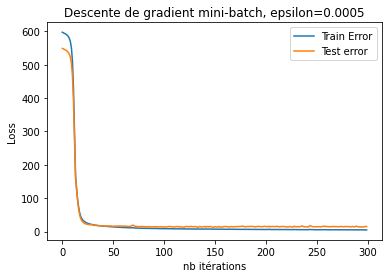

Itérations 0: test loss 551.0563247074671
Itérations 50: test loss 15.7999843807369
Itérations 100: test loss 22.28477352342401
Itérations 150: test loss 19.520149428461043
Itérations 200: test loss 22.187016508013507
Itérations 250: test loss 20.054625736056174
Itérations 299: test loss 20.271191660568324


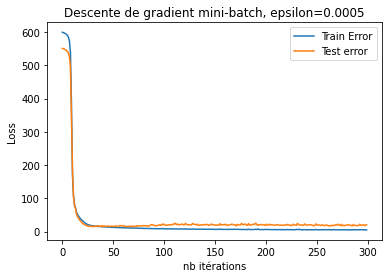

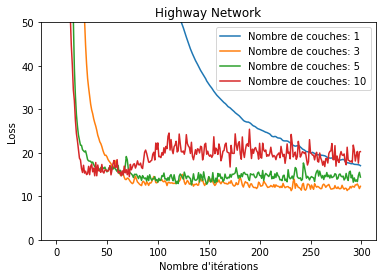

In [27]:
arrayNbLayers = [1,3,5,10]
arrayRes = []
nb_epochs = 300
for layer in arrayNbLayers:
    NN = Highway(layer,X_train,X_test,y_train,y_test,epsilon=0.0005)
    NNtrainError, NNTestError = NN.run(nb_epochs)
    arrayRes.append(NNTestError)
for i in range(len(arrayRes)):
    plt.plot([i for i in range(nb_epochs)],arrayRes[i],label="Nombre de couches: {}".format(arrayNbLayers[i]))
plt.ylabel("Loss")
plt.xlabel("Nombre d'itérations")
plt.title("Highway Network")
plt.legend()
plt.ylim(0,50)
plt.savefig("Highway")
plt.show()